# Generalized Linear Models Comparison

All three **Generalized Linear Models (GLM)** currently available in scikit-learn have been integrated for FHE in Concrete ML: PoissonRegressor, GammaRegressor and TweedieRegressor. Choosing the best GLM directly depends on the initial problem one has to solve, and more specifically, how the target values are distributed.  Detailed information about those models can be found in their associated [documentation](https://scikit-learn.org/stable/modules/classes.html#:~:text=Generalized%20linear%20models%20(GLM)) as well as their [user guide](https://scikit-learn.org/stable/modules/linear_model.html#:~:text=vs%20other%20solvers%E2%80%9D-,1.1.12.%20Generalized%20Linear%20Regression).

This notebook shows how to train these models and run them in FHE using Concrete ML. It is highly inspired by this [notebook](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html) from scikit-learn so that users can appreciate how similar Concrete ML is to the library.

A deeper analysis on the impact of quantization and FHE computations over a model's performance in comparison to its scikit-learn equivalent one is available in the [PoissonRegressor notebook](PoissonRegression.ipynb).

### Import libraries

We import scikit-learn libraries, Concrete quantization tools as well as the Poisson, Gamma and Tweedie regression model from both scikit-learn and Concrete ML:

In [1]:
# Source : https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html # noqa # pylint: disable=line-too-long

# Authors: Christian Lorentzen <lorentzen.ch@gmail.com>
#          Roman Yurchak <rth.yurchak@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
# Modified to integrate Concrete ML functions by Zama
# License: BSD 3 clause

import sys
import time
from collections import defaultdict
from timeit import default_timer as timer

import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.linear_model import GammaRegressor as SklearnGammaRegressor
from sklearn.linear_model import PoissonRegressor as SklearnPoissonRegressor
from sklearn.linear_model import TweedieRegressor as SklearnTweedieRegressor
from sklearn.metrics import mean_gamma_deviance, mean_poisson_deviance, mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

from concrete.ml.sklearn import GammaRegressor as ConcreteGammaRegressor
from concrete.ml.sklearn import PoissonRegressor as ConcretePoissonRegressor
from concrete.ml.sklearn import TweedieRegressor as ConcreteTweedieRegressor

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### Fetching and cleaning the data

First, we download the data. It is composed of two data-sets that will be joined together:
- the original one containing most risks features for 677,991 policies, each identified by an unique ID
- an additional one only containing amounts claimed for some of those policies, matching the same IDs

Since the regressors are not meant to be used for similar target values distributions, the second data-set will mainly be used for the Gamma regression model.

In [3]:
# Getting the original data-set containing the risk features
# Link: https://www.openml.org/d/41214
risks_data, _ = fetch_openml(
    data_id=41214, as_frame=True, cache=True, data_home="~/.cache/sklearn", return_X_y=True
)

# Getting the data set containing claims amount
# Link: https://www.openml.org/d/41215
claims_data, _ = fetch_openml(
    data_id=41215, as_frame=True, cache=True, data_home="~/.cache/sklearn", return_X_y=True
)

Then, some transformation needs to be made over that downloaded data. They include:
- making proper changes so that merging the data-sets is possible
- only keeping part of the data-set for faster computations
- filtering unknown and null values for claim amounts
- removing outliers

Those steps are very useful for making the model better fit the data.

In [4]:
# Set IDpol as index
risks_data["IDpol"] = risks_data["IDpol"].astype(int)
risks_data.set_index("IDpol", inplace=True)

# Grouping claims mounts together if they are associated with the same policy
claims_data = claims_data.groupby("IDpol").sum()

# Merging the two sets over policy IDs
data = risks_data.join(claims_data, how="left")

# Only keeping the first 100 000 for faster running time
data = data.head(100000)

# Filtering out unknown claim amounts
data["ClaimAmount"].fillna(0, inplace=True)

# Filtering out claims with zero amount, as the severity (gamma) model
# requires strictly positive target values
data.loc[(data["ClaimAmount"] == 0) & (data["ClaimNb"] >= 1), "ClaimNb"] = 0

# Removing unreasonable outliers
data["ClaimNb"] = data["ClaimNb"].clip(upper=4)
data["Exposure"] = data["Exposure"].clip(upper=1)
data["ClaimAmount"] = data["ClaimAmount"].clip(upper=200000)

### Transforming the data

We now proceed by transforming the raw features into ones that can be given to a regression model. Thus, the categorical features are transformed using one-hot encoding while the resolution of vehicle and person ages is reduced using binning. Transforming the data this way, we end up with a total of 74 continuous features instead of the initial 12 ones.

In [5]:
log_scale_transformer = make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler())

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(sparse=False),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

x = linear_model_preprocessor.fit_transform(data)

### Creating the target values

Each GLM regressors expect different kind of distributions for the target values:
- **Poisson** is a discrete model that expects target values to be non-negative and to follow a Poisson distribution. It can be used for modelling counts or relative frequencies (if scaled). This model is equivalent to a Tweedie model with power set to 1.
- **Gamma** is a continuous model that expects target values to be (strictly) positive and to follow a Gamma distribution. It is often useful when values are skewed. This model is equivalent to a Tweedie model with power set to 2.
- **Tweedie** is a continuous model that expects target values to follow a Tweedie distribution of fixed *power*. Depending on its *power* value, target values should either be non-negative or (strictly) positive. It can be useful for heavier tailed distribution when *power* is set to 3.

We therefore create target values so that they each follow the desired distributions:

In [6]:
# Creating target values for Poisson
data["Frequency"] = data["ClaimNb"] / data["Exposure"]

# Creating target values for Gamma
data["AvgClaimAmount"] = data["ClaimAmount"] / np.fmax(data["ClaimNb"], 1)

# Creating target values for Tweedie
# Insurances companies are interested in modeling the Pure Premium, that is the expected total
# claim amount per unit of exposure for each policyholder in their portfolio
data["PurePremium"] = data["ClaimAmount"] / data["Exposure"]

We can then plot their histograms on a log scale and confirm that they each approximately follow the desired distributions: an exponential distribution, with more skewed values for the AvgClaimAmount variable as well as a heavy tail for the PurePremium one:

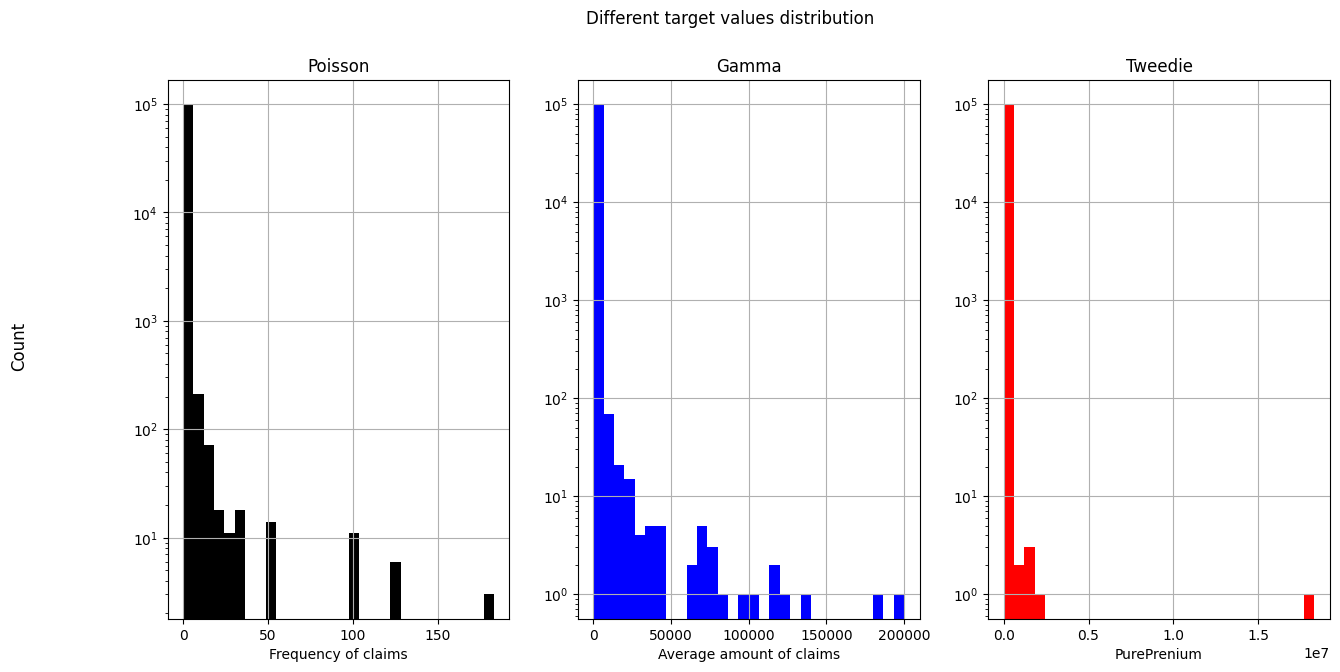

In [7]:
plt.ioff()
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

# Set the figure's main parameters
fig.patch.set_facecolor("white")
fig.suptitle("Different target values distribution")
fig.supylabel("Count")

# Frequency of claims distribution
ax[0].set_title("Poisson")
ax[0].set_xlabel("Frequency of claims")
data["Frequency"].hist(bins=30, log=True, ax=ax[0], color="black")

# Average amount of claims distribution
ax[1].set_title("Gamma")
ax[1].set_xlabel("Average amount of claims")
data["AvgClaimAmount"].hist(bins=30, log=True, ax=ax[1], color="blue")

# PurePrenium distribution
ax[2].set_title("Tweedie")
ax[2].set_xlabel("PurePrenium")
data["PurePremium"].hist(bins=30, log=True, ax=ax[2], color="red")

display(fig)

### Splitting the data

We then split the data into a training and test set. The test set is then reduced for faster FHE runs.

In [8]:
train_data, test_data, x_train_data, x_test_data = train_test_split(
    data,
    x,
    test_size=0.2,
    random_state=0,
)
_, test_data, _, x_test_data = train_test_split(
    test_data,
    x_test_data,
    test_size=50,
    random_state=0,
)

### Setting the right parameters

Each regressors do neither share exactly the same parameers nor are trained over the same data (for example, Gamma only considers strictly positive target values):

In [9]:
gamma_mask_train = train_data["ClaimAmount"] > 0
gamma_mask_test = test_data["ClaimAmount"] > 0


parameters_glms = {
    "Poisson": {
        "sklearn": SklearnPoissonRegressor,
        "concrete": ConcretePoissonRegressor,
        "init_parameters": {
            "alpha": 1e-3,
            "max_iter": 400,
        },
        "fit_parameters": {
            "X": x_train_data,
            "y": train_data["Frequency"],
            "sample_weight": train_data["Exposure"],
        },
        "x_test": x_test_data,
        "score_parameters": {
            "y_true": test_data["Frequency"],
            "sample_weight": test_data["Exposure"],
        },
        "deviance": mean_poisson_deviance,
    },
    "Gamma": {
        "sklearn": SklearnGammaRegressor,
        "concrete": ConcreteGammaRegressor,
        "init_parameters": {
            "alpha": 10.0,
            "max_iter": 300,
        },
        "fit_parameters": {
            "X": x_train_data[gamma_mask_train],
            "y": train_data[gamma_mask_train]["AvgClaimAmount"],
            "sample_weight": train_data[gamma_mask_train]["ClaimNb"],
        },
        "x_test": x_test_data[gamma_mask_test],
        "score_parameters": {
            "y_true": test_data[gamma_mask_test]["AvgClaimAmount"],
            "sample_weight": test_data[gamma_mask_test]["ClaimNb"],
        },
        "deviance": mean_gamma_deviance,
    },
    "Tweedie": {
        "sklearn": SklearnTweedieRegressor,
        "concrete": ConcreteTweedieRegressor,
        "init_parameters": {
            "power": 1.9,
            "alpha": 0.1,
            "max_iter": 10000,
        },
        "fit_parameters": {
            "X": x_train_data,
            "y": train_data["PurePremium"],
            "sample_weight": train_data["Exposure"],
        },
        "x_test": x_test_data,
        "score_parameters": {
            "y_true": test_data["PurePremium"],
            "sample_weight": test_data["Exposure"],
            "power": 1.9,
        },
        "deviance": mean_tweedie_deviance,
    },
}

### Comparing the models

The following function iterates over the three GLM regressors and outputs scores from both the sklearn and concrete models for each regressors. Basically, it:
- instantiates both models
- fits both models
- compiles the Concrete ML model if it needs to be executed in FHE
- computes the predictions for both models
- computes the scores for both models using the proper deviance function

The score used here is the mean deviance score. It indicates the goodness-of-fit of a model and is widely used for evaluating the performances of a GLM. The lower the score, the better !

In [10]:
def compare_regressors(n_bits, fhe="simulate"):
    # pylint: disable=too-many-locals
    scores = defaultdict(list)
    predictions = defaultdict(list)

    for glm, parameters_glm in parameters_glms.items():
        # Retrieve the regressors
        sklearn_class = parameters_glm["sklearn"]
        concrete_class = parameters_glm["concrete"]

        # Instantiate the models
        init_parameters = parameters_glm["init_parameters"]
        sklearn_glm = sklearn_class(**init_parameters)
        concrete_glm = concrete_class(n_bits=n_bits, **init_parameters)

        # Fit the models
        fit_parameters = parameters_glm["fit_parameters"]
        sklearn_glm.fit(**fit_parameters)
        concrete_glm.fit(**fit_parameters)

        x_train_subset = fit_parameters["X"][:100]
        # Compile the Concrete ML model if it needs to be executed in FHE
        if fhe in ["execute", "simulate"]:
            circuit = concrete_glm.compile(x_train_subset)

            # Generate the key
            print(
                "Generating a key for an "
                f"{circuit.graph.maximum_integer_bit_width()}-bit circuit"
            )
            sys.stdout.flush()

            time_begin = time.time()
            circuit.client.keygen(force=False)
            print(f"Key generation time: {time.time() - time_begin:.4f} seconds")

        # Compute the predictions using sklearn (floating points, in the clear)
        x_test = parameters_glm["x_test"]
        sklearn_predictions = sklearn_glm.predict(x_test)

        # Compute the predictions using Concrete ML (quantized, in the clear)
        concrete_q_predictions = concrete_glm.predict(x_test)

        # Compute the predictions using Concrete ML (in FHE)
        start = timer()
        concrete_predictions = concrete_glm.predict(
            x_test,
            fhe=fhe,
        )
        end = timer()
        run_time = end - start

        # Compute the deviance scores
        mean_deviance = parameters_glm["deviance"]
        score_parameters = parameters_glm["score_parameters"]
        sklearn_score = mean_deviance(y_pred=sklearn_predictions, **score_parameters)
        concrete_q_score = mean_deviance(y_pred=concrete_q_predictions, **score_parameters)
        concrete_score = mean_deviance(y_pred=concrete_predictions, **score_parameters)

        # Print the deviance scores
        fhe_message = "in FHE" if fhe == "execute" else "in clear"
        print(f"Mean {glm} deviance (scikit-learn): {sklearn_score:.4f}")
        print(f"Mean {glm} deviance (Concrete ML, quantized): {concrete_q_score:.4f}")
        print(
            f"Mean {glm} deviance (Concrete ML {fhe_message}, "
            f"with {run_time / len(x_test):.4f} seconds "
            f"per inference): {concrete_score:.4f}"
        )

        # Measure the error of the FHE quantized model with respect to the clear scikit-learn
        # float model
        score_difference = abs(concrete_score - sklearn_score) * 100 / sklearn_score
        print(
            "Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores:",
            f"{score_difference:.2f}%\n",
        )

        # Store the results
        scores["sklearn"].append(sklearn_score)
        scores["concrete"].append(concrete_score)
        predictions["sklearn"].append(sklearn_predictions)
        predictions["concrete"].append(concrete_predictions)

    return scores, predictions

As for all linear models available in Concrete ML, a user has to set the `n_bits` parameter for 
initialization. This parameter can either be:
- a dictionary composed of `op_inputs` and `op_weights` keys. These parameters are given as 
    integers representing the number of bits over which the associated data should be quantized.

- an integer, representing the number of bits over which each input and weight should be quantized.
    Default is 8.

Additionally, Concrete ML lets the users chose whether the model should be ran in clear or FHE using the `fhe` parameter. Setting it to "disable" will run the model on unencrypted data using the same quantization process.

In [11]:
n_bits = 11
fhe = "execute"

scores, predictions = compare_regressors(n_bits, fhe=fhe)

Generating a key for an 25-bit circuit


Key generation time: 0.0002 seconds


Mean Poisson deviance (scikit-learn): 1.1568
Mean Poisson deviance (Concrete ML, quantized): 1.1589
Mean Poisson deviance (Concrete ML in FHE, with 0.0072 seconds per inference): 1.1589
Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores: 0.19%



Generating a key for an 24-bit circuit


Key generation time: 0.0001 seconds
Mean Gamma deviance (scikit-learn): 0.3179
Mean Gamma deviance (Concrete ML, quantized): 0.3180
Mean Gamma deviance (Concrete ML in FHE, with 0.0075 seconds per inference): 0.3180
Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores: 0.03%



Generating a key for an 25-bit circuit


Key generation time: 0.0002 seconds


Mean Tweedie deviance (scikit-learn): 37.6493
Mean Tweedie deviance (Concrete ML, quantized): 37.7585
Mean Tweedie deviance (Concrete ML in FHE, with 0.0073 seconds per inference): 37.7585
Relative difference between scikit-learn (clear) and Concrete-ml (FHE) scores: 0.29%



### Analysis
We can observe that scikit-learn and Concrete ML models output have very close mean deviance scores. This demonstrate how the quantization process has a very limited impact on performances. 

### Conclusion

This notebook was greatly inspired by [this notebook](https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html) from scikit-learn which showed how to use three Generalized Linear Model (GLM) regressors they implemented (Poisson, Gamma and Tweedie) in a real regression problem.

We then modified some of its content in order to demonstrate how running these models in Fully Homomorphic Encryption (FHE) can be very similar to the sklearn workflow using the Concrete ML framework. 

Finally, comparing the mean deviance scores from both models over each regressors revealed how quantization has a negligible impact on their performances, thus making Concrete ML's models reach almost identical results with respect to their equivalent scikit-learn ones.